# Networks in NeuroDyn

## Overview

This notebook provides a guide to specyfing neural interconnections and designing networks using Hodgkin-Huxley and NeuroDyn models in Python environment. We first start with an overview of two main types of neural interconnections: gap junctions and synapses, and how to implement them in the software environment. The environment allows defining arbitrary conductance-based models of synapses, and we give an example here using an excitatory AMPA synapse. Networks can be constructed using both the standard Hodgkin-Huxley models as well as NeuroDyn neurons, and the notebook shows how we can specify both types. 

Finally, we introduce two additional classes `NeuroDynBoard` and `NeuroCube` which specify the NeuroDyn hardware structure:
- `NeuroDynBoard` is a single NeuroDyn board containing 4 neurons and 12 synapses.
- `NeuroCube` is a parallel interconnection of 4 NeuroDyn boards, where the boards are connected through mutural resistive connections.

## Setting up the environment

Let's first import the required Python modules and model definitions:

In [1]:
import matplotlib.pyplot as plt
from cb_models import HHModel, NeuroDynModel, NeuronalNetwork, Synapse, NDSynapse
from cb_models import AMPA
from fitting_utilities import FitND

# **Ignore overflow warnings**
import numpy as np
np.seterr(all="ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Overview of neural interconnections

There are two main types of neural interconnections that we can implement: **gap junctions** and **synaptic connections**. In the conductance-based modelling framework, these interconnections lead to additional currents in the membrane equation of neuron $i$ that are dependent on membrane voltages of other neurons $j$ connected to it:

\begin{equation}
C \dot{V}_i = - I_{int,i} - \sum_{j} I_{gap, i, j} - \sum_{j} I_{syn, i, j} + I_{app, i}
\end{equation}

where $I_{int,i}$ is total internal current of the neuron, $I_{gap, i, j}$ is the current due to the gap junction between neurons $j$ and $i$, $I_{syn, i, j}$ is the synaptic current from neuron $j$, and $I_{app, i}$ is the external current applied to neuron $i$.

### Gap junctions

Gap junctions are modeled as simple resistive connections between neurons, so that a resistive connection between neurons $i$ and $j$ leads to a current in neuron $i$:

\begin{equation}
I_{gap, i, j} = g_{gap, i, j} (V_i - V_j)
\end{equation}

Gap junction interconnections are symmetric $g_{gap, i, j} = g_{gap, j, i}$, so that:

\begin{equation}
I_{gap, j, i} = -I_{gap, i, j}
\end{equation}

and neuron $j$ receives the same current of the opposite sign.

We can represent this as a matrix $G_{gap}$ where each element $g_{gap, i, j}$ is the conductance of the connection between neurons $i$ and $j$. This matrix is necessarily **symmetric**, i.e. $G_{gap} = G^T_{gap}$.

### Synaptic connections

Unlike gap junctions, synaptic connections are directed connections and are not symmetric. If there is a synapse from neuron $j$ to neuron $i$, then the activity of the *presynaptic* neuron ($j$) modulates the activity of the *postsynaptic* neuron ($i$). Synaptic currents have a similar form to the internal ionic currents, with the difference that their activation depends on the activity of the presynaptic neuron. This is observed in the dependency of the opening rate $\alpha_r$ on the presynaptinc neuron voltage $V_j$:

\begin{equation}
I_{syn, i, j} = \bar{g}_{syn, i, j} r (V_i - E_{syn}) \\
\dot{r} = \alpha_r(V_j) (1 - r) - \beta_r(V_i) r
\end{equation}

The opening of the channels $\alpha_r$ depends on the presynaptic neuron's voltage $V_j$, while the closing depends on the postsynaptic neuron's voltage $V_i$ (sometimes this relationship is modeled as constant, so that $\beta_r = const$).

The reversal potential of the synapse $E_{syn}$ determines if the synapse is *excitatory* or *inhibitory*: excitatory synapses tend to increase the postsynaptic neuron's voltage, while the inhibitory synapses act to decrease the postynaptic voltage. On the other hand, dynamics of activation $r$ determines the timescale of the synaptic current, i.e. how fast it activates in relation to the changes in the presynaptic neuron.

## Defining neural interconnections

Let's now see how we can define these interconnections in the Python environment. We start with a simple example of two Hodgkin-Huxley neurons, which we can define as before:

In [2]:
neuron1 = HHModel()
neuron2 = HHModel()

### Gap junctions

Let's start with a simple network consisting of a single gap junction between these two neurons with $g_{gap} = 0.1$. We do this by defining the matrix `G_gap` and passing it as a keyword argument along with a list of the neurons to our `NeuronalNetwork` class:

In [3]:
neurons = [neuron1, neuron2]
g = 0.1
G_gap = [[0, g], [g, 0]] # needs to be symmetric

network = NeuronalNetwork(neurons, gap = G_gap)

We simulate the network exactly as before by calling the method `simulate`. This time, the applied current function needs to return an array of external currents corresponding to each neuron in the `neurons` list. Additionally, we need to make sure that the initial condition array `x0` has the right number of states:

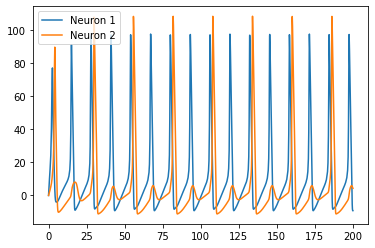

In [4]:
# Simulation time
T = 200
trange = (0, T)

# External current
I1 = 15 # current to neuron 1
I2 = 0 # current to neuron 2
Iapp = lambda t: [I1, I2]

# Initial condition
x0 = [0, 0, 0, 0] * 2

# Simulate
sol = network.simulate(trange, x0, Iapp)
V1 = sol.y[0]
V2 = sol.y[4]

plt.figure()
plt.plot(sol.t, V1, label = "Neuron 1")
plt.plot(sol.t, V2, label = "Neuron 2")
plt.legend()
plt.show()

You can change the conductance of the gap junction and observe the different behavior. For very small values of the conductance, the neurons are effectivey disconnected and act independently, while gradually increasing the conductance will bring the membrane voltages of the two neurons closer together.

Making $g_{gap}$ large effectively acts as the short-circuit between the two neurons (but be careful about making it too large as it may lead to numerical issues).

### Synaptic connections

Let's now see how we can introduce a synapse from neuron 1 to neuron 2. We first need to create an object for the synapse of the `Synapse` class which takes three arguments: `gsyn` - maximal conductance, `Esyn` - reversal potential, `r` - gating variable object.

The `r` gating variable should be derived from the class `HHKinetics` and needs to provide methods `alpha` and `beta` that define the functions $\alpha_r(V)$ and $\beta_r(V)$.

#### AMPA synapse

As an example, let's take a look at implementing an excitatory AMPA synapse. There is an `AMPA` gating kinetics class already provided that takes the values from Ermentrout et al. 2010 that we can use here. Let's define a synapse using the `AMPA` kinetics class, setting the value of the reversal potential to $E_{AMPA} = 65mV$ (the reversal potential value is shifted to accomodate for the shift in the Hodgkin-Huxley model that sets $V_{rest} = 0mV$):

In [5]:
r = AMPA()
gsyn = 0.05
Esyn = 65
synapse = Synapse(gsyn, Esyn, r)

Having defined the model of the synapse that we would like to use, we now need to define the connectivity matrix describing all of the synaptic connections in the network. For this, we will construct a matrix `syns` where each element of the matrix $(i, j)$ contains a **list** of all synaptic connections from neuron $j$ to neuron $i$. If there are no synaptic connections from neuron $j$ to neuron $i$, then we set that matrix element to `None`.

Since we would like to define a single excitatory synapse from neuron 1 to neuron 2, we will put a single `Synapse` object into a list at position (1, 0), filling the rest of the matrix with `None`. Let's create a new network with the single excitatory synapse and simulate it:

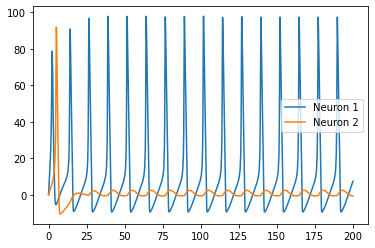

In [6]:
syns = [[None, None], [[synapse], None]]

network = NeuronalNetwork(neurons, syns = syns)

# Simulation time
T = 200
trange = (0, T)

# External current
I1 = 15 # current to neuron 1
I2 = 0 # current to neuron 2
Iapp = lambda t: [I1, I2]

# Initial condition
x0 = [0, 0, 0, 0] * 2 + [0] # extra state due to the synapse!

# Simulate
sol = network.simulate(trange, x0, Iapp)
V1 = sol.y[0]
V2 = sol.y[4]

plt.figure()
plt.plot(sol.t, V1, label = "Neuron 1")
plt.plot(sol.t, V2, label = "Neuron 2")
plt.legend()
plt.show()

We can observe that each time the first neuron spikes it excites the second neuron. If the strength of the synapse is large enough, the second neuron will start spiking in response to the activity of the second neuron. We can play around with the synaptic strenght and observe the different behavior:

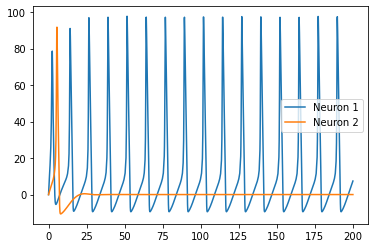

In [104]:
synapse.gsyn = 0 # change the synapse strength

# Simulate
sol = network.simulate(trange, x0, Iapp)
V1 = sol.y[0]
V2 = sol.y[4]

plt.figure()
plt.plot(sol.t, V1, label = "Neuron 1")
plt.plot(sol.t, V2, label = "Neuron 2")
plt.legend()
plt.show()

#### Defining different synapse models

You can use the `Synapse` class to define arbitrary synaptic connections - the main requirement is implementing a gating variable class inherited from the `HHKinetics` class that needs to define implementations for the methods `alpha(V)` and `beta(V)`. You can take a look at how the `AMPA` class is defined in the `cb_models` file to get a better idea.

**Note** that since our original Hodgkin-Huxley model has parameter values shifted so that the resting potential is at $V_{rest} = 0mV$, you might need to shift biophyiscal values accordingly in order to make the synapse compatible with the model.

Another important thing to note is that when we try to fit activation dynamics to the NeuroDyn hardware, the values should be in **SI units**.

Finally, if we would like to stretch the voltage range of the Hodgkin-Huxley model using the `scl_v` parameter, the range of the synapse would need to be stretched accordingly to accommodate for this. It is therefore best to implement an optional keyword `scl_v` to the gating variable class that would multiply the voltage-related parameters (you can check this for the `AMPA` class and the `HHModel` class in the file `cb_models`).

## NeuroDyn network

Let's see now how we can do the same using NeuroDyn models for the individual neurons, as well as the synapses.

### NeuroDyn synapse

A synaptic connection in the NeuroDyn hardware is implemented in very much the same way as ionic conductance dynamics was for a single neuron (see "NeuroDyn equations" section in **NeuroDyn Python model** notebook). Therefore, a NeuroDyn synapse class `NDSynapse` will be defined using the following digital parameters:

- `dg`: digital value for the maximal conductance
- `dE`: digital value for the reversal potential
- `dIb`: digital values for the alpha and beta sigmoid weights
    - `dIb` is a list containing `[dIalpha, dIbeta]`
    - each `dIalpha` and `dIbeta` is an array of 7 digital values for the sigmoid weights
- `ND`: optional keyword argument containing a `NeuroDynModel` object
    - the synapse will take all physical parameters such as `I_master` and `I_voltage` from this object, so it should be the 'parent' NeuroDyn neuron for the synapse
    - if no `ND` object is passed, `NDSynapse` will be initialized with a default `NeuroDynModel` object
    
In order to find these digital values we can again try fitting the parameters so that they replicate a particular biophysical synapse. As an example, let's try fitting the parameters to the AMPA synapse of the previous section.

### Fitting a synapse

In order to fit a synapse model, we can again use the class `FitND` that we have previously used to fit a Hodgkin-Huxley model to a NeuroDyn neuron. We first fit an appropriate Hodgkin-Huxley model as before, after which we can pass any other gating variables that we would like to fit to. In this case, we want to fit the AMPA gating variable.

First, let's repeat the procedure of fitting a NeuroDyn neuron as before:

In [7]:
# Fit Hodgkin-Huxley model

scl_v = 3 # voltage scaling

# Hodgkin-Huxley model we want to fit to
hh_neuron = HHModel(scl_v = scl_v, SI_units = True)

# Create a fitting object and obtain the initial fit
fit_obj = FitND(hh_neuron)

weights = fit_obj.fitHH()

g0 = [120e-3,36e-3,0.3e-3] # maximal conductances
E0 = [120e-3,-12e-3,10.6e-3] # reversal potentials

dIb = fit_obj.get_digital_Ib(weights)
dg = fit_obj.get_digital_g(g0)
dE = fit_obj.get_digital_E(E0)
dIb[2][1] = dIb[2][1]*15

I_master = fit_obj.I_master
I_voltage = fit_obj.I_voltage

V_ref = 0.9

ND1 = NeuroDynModel(dg, dE, dIb, V_ref, I_voltage, I_master)

Now, let's follow the same procedure in order to get the parameters for an AMPA synapse. We first make an AMPA gating variable (remember that it needs to be scaled appropriately, which we do by passing the `scl_v` keyword).

We can then pass the `AMPA` gating variable, along with any other gating variables we would like to fit to, to the `fit` method. Importantly, note that a **list** of gating variables should be passed as an argument, along with an optional list `labels` for the figure labels.

Another important thing to note is that each time we fit new gating variables using an existing `FitND` object, the `scl_t` variable determining the time scaling will adjust so that the maximal coefficient encountered so far fits within the NeuroDyn constraints. If we would like to fit gating variables without readjusting the scale, we can pass an optional keyword argument `update_scale = False`. This means that our fitting process might return parameters that are outside the digital range. Here we will keep the default `update_scale` that is set to `True`.

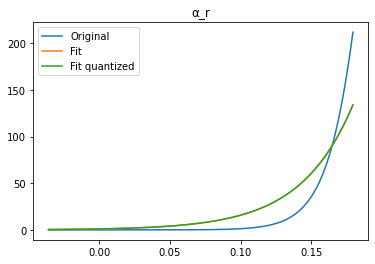

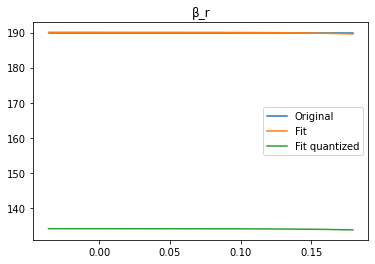

In [8]:
# Fit AMPA gating variable
r = AMPA(scl_v = scl_v, SI_units = True)

# Fit weights to AMPA
weights_syn = fit_obj.fit([r], labels = ['r'], plot_alpha_beta = True) # note that gating variables are passed in a list

weights_syn = weights_syn[0] # fitting method returns a list of gating variables

Having obtained the weights for the gating variable kinetics, we can then get the digital parameters for the maximal conductance and the reversal potential of the synapse, and use that to create an `NDSynapse` object. Apart from the maximal conductance, reversal potential, and the gating variable, the `NDSynapse` object also accepts a reference to a NeuroDyn object from which it takes physical constants and currents $I_{voltage}$ and $I_{master}$.

In [114]:
gsyn = 0.3e-3 # max coductance of the synapse
Esyn = 65e-3 # reversal potential of the synapse

dIb_syn = fit_obj.get_digital_Ib(weights_syn)
dgsyn = fit_obj.get_digital_g(gsyn)
dEsyn = fit_obj.get_digital_E(Esyn)

nd_syn = NDSynapse(dgsyn, dEsyn, dIb_syn, ND1)

### Creating a network

Having created an object for our synapse, we can now define a network in exactly the same way as before! Let's define a second neuron `ND2` with the same parameters, but let's decrease the applied current to this neuron in order to make it silent. For convenience, we can `deepcopy` our first neuron, so that the second neuron has the same parameters but does not share any variables with the first neuron. Let's set the appropriate current $I_{app}$ so that the neuron is silent:

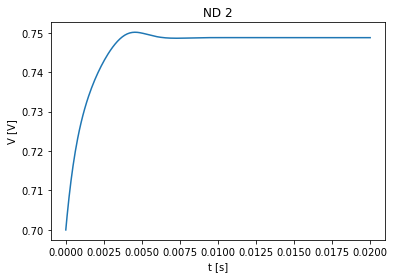

In [15]:
from copy import deepcopy

ND2 = deepcopy(ND1)

I2 = -1e-6
Iapp = lambda t : fit_obj.convert_I(I2)

V_ref = 0.9

T = 0.02
trange = (0, T)

sol = ND2.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t [s]')
plt.ylabel('V [V]')
plt.title('ND 2')
plt.plot(sol.t, sol.y[0])
plt.show()

Now that we have our two neurons `ND1` and `ND2`, let's set up the excitatory synapse we have created from `ND1` to `ND2` so that the first neuron spiking excites the resting second neuron.

In [116]:
nd_neurons = [ND1, ND2]

nd_syns = [[None, None], [None, None]]

nd_network = NeuronalNetwork(nd_neurons, syns = nd_syns)

# Simulation time
T = 0.02
trange = (0, T)

# External current
I1 = fit_obj.convert_I(0e-6) # current to neuron 1
I2 = fit_obj.convert_I(-2e-6) # current to neuron 2
Iapp = lambda t: [I1, I2]

# Initial condition
x0 = [0.7, 0, 0, 0] * 2 #+ [0] # extra state due to the synapse

# Simulate
sol = nd_network.simulate(trange, x0, Iapp)
V1 = sol.y[0]
V2 = sol.y[4]

plt.figure()
plt.plot(sol.t, V1, label = "Neuron 1")
plt.plot(sol.t, V2, label = "Neuron 2")
plt.legend()
plt.show()

ValueError: setting an array element with a sequence.

## NeuroDyn board